# L'algoritmo CYK

## La tabella, sua relazione con l'input

In [ ]:
INPUT = 'atest'

R = {}
for l in range(1, len(INPUT) + 1):
    for i in range(1, len(INPUT) - l + 2): 
        R[(i, l)] = INPUT[i - 1 : i + l - 1]

R

{(1, 1): 'a',
 (2, 1): 't',
 (3, 1): 'e',
 (4, 1): 's',
 (5, 1): 't',
 (1, 2): 'at',
 (2, 2): 'te',
 (3, 2): 'es',
 (4, 2): 'st',
 (1, 3): 'ate',
 (2, 3): 'tes',
 (3, 3): 'est',
 (1, 4): 'ates',
 (2, 4): 'test',
 (1, 5): 'atest'}

In [ ]:
# usiamo liblet per avere una visualizzazione in forma tabellare

from liblet import cyk2table

cyk2table(R)

### Riempimento offline

In [ ]:
def offline(fill, n):
    R = {}
    for l in range(1, n + 1):
        for i in range(1, n - l + 2): 
            R[(i, l)] = fill(R, i, l)
    return R

In [ ]:
def fill_with_nij(R, i, j):
    global n
    n += 1
    return '{} @ ({}, {})'.format(n, i, j)

In [ ]:
n = 0
cyk2table(offline(fill_with_nij, 5))

### Riempimento online

In [ ]:
def online(fill, n):
    R = {}
    for d in range(1, n + 1):
        for i in range(d, 0, -1):
            R[(i, d - i + 1)] = fill(R, i, d - i + 1)
    return R

In [ ]:
n = 0
cyk2table(online(fill_with_nij, 5))

## Predicati e flitri

In [ ]:
# un predicato è una funzione a valori booleani

def pari(x):
    return x % 2 == 0

In [ ]:
# la funzione filter restituisce, dato un predicato e un iterabile,
# il sottoiterabile degli elementi che soddisfano il predicato

list(filter(pari, range(10)))

[0, 2, 4, 6, 8]

In [ ]:
# le Production possono costruire predicati basati, ad esempio, sul
# numero di simboli del lato destro

from liblet import Production

prods = Production.from_string("""
A -> a
A -> B C
""")
prods

(A -> a, A -> B C)

In [ ]:
# la prima produzione ha il lato destro lungo 1 simbolo? 

Production.such_that(rhs_len = 1)(prods[0])

True

In [ ]:
# filtra le produzioni tali che il lato destro è lungo 2

list(filter(Production.such_that(rhs_len = 2), prods))

[A -> B C]

In [ ]:
# filtra le produzioni tali che il lato destro è lungo 1

list(filter(Production.such_that(rhs_len = 1), prods))

[A -> a]

## Riempimento usando G (CNF) e input

In [ ]:
from liblet import Production 

def cyk_fill(G, INPUT):
    def fill(R, i, l):
        res = set()
        if l == 1:
            for A, (a,) in filter(Production.such_that(rhs_len = 1), G.P): 
                if a == INPUT[i - 1]: res.add(A)
        else:
            for k in range(1, l):
                for A, (B, C) in filter(Production.such_that(rhs_len = 2), G.P):
                    if B in R[(i, k)] and C in R[(i + k, l - k)]: res.add(A)
        return res
    return fill

### Un esempio elementare

In [ ]:
# un esempio con una grammatica banale per il linguaggio a^n.

from liblet import Grammar

G = Grammar.from_string("""
S -> A S
A -> a
S -> .
""")

In [ ]:
# parola accettata 

INPUT = 'aaa.'

R = online(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

In [ ]:
# parola non accettata 

INPUT = 'aaa'

R = online(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

### Un esempio dal libro di testo

In [ ]:
# fig. 4.15, pag. 123 

# Questa grammatica (che contiene alcuni non terminali "artificiali") è 
# il risultato della trasformazione in CNF di una grammatica più naturale 
# che vedremo la prossima lezione

G = Grammar.from_string("""
Number -> 0|1|2|3|4|5|6|7|8|9 
Number -> Integer Digit
Number -> N1 Scale' | Integer Fraction
N1 -> Integer Fraction
Integer -> 0|1|2|3|4|5|6|7|8|9 
Integer -> Integer Digit
Fraction -> T1 Integer
T1 -> .
Scale' -> N2 Integer
N2 -> T2 Sign
T2 -> e
Digit -> 0|1|2|3|4|5|6|7|8|9 
Sign -> + | -
""")

In [ ]:
INPUT = '32.5e+1'

R = offline(cyk_fill(G, INPUT), len(INPUT))
cyk2table(R)

# <span style="color: red;">Per casa</span>: l'albero di parsing (barando) 

La tabella contiene non terminali e, in accordo al criterio usato per riempirla, tali non terminali possono essere raccolti in un albero che ha l'aspetto di un albero di derivazione — anche se costruito senza riferimento alle produzioni (dal quale non è quindi banale ricostruire la derivazione).

Scriviamo una procedura che, dati in ingresso la tabella `R`, la grammatica e l'input, restituice una funzione ricorsiva `tree` che, dato un non terminale, il punto d'inizio e la lunghezza, restituisca un *lol* che rappresenta l'albero di parsing radicato in quel non terminale e che deriva la sottostringa specificata.

In [ ]:
def get_parse_tree(G, R, INPUT):
    def tree(X, i, l):
        if l == 1: return [X, [INPUT[i-1]]]
        for A, (B, C) in filter(Production.such_that(lhs = X, rhs_len = 2), G.P):
            for k in range(1, l):
                if B in R[(i, k)] and C in R[(i + k, l - k)]:
                    return [A, tree(B, i, k), tree(C, i + k, l - k)]
    return tree(G.S, 1, len(INPUT))    

In [ ]:
lol = get_parse_tree(G, R, INPUT)
lol

['Number',
 ['N1',
  ['Integer', ['Integer', ['3']], ['Digit', ['2']]],
  ['Fraction', ['T1', ['.']], ['Integer', ['5']]]],
 ["Scale'", ['N2', ['T2', ['e']], ['Sign', ['+']]], ['Integer', ['1']]]]

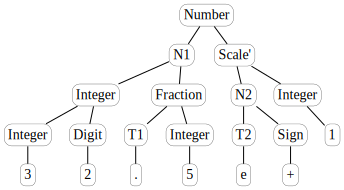

In [ ]:
# possiamo ora visualizzarlo 

from liblet import Tree

Tree.from_lol(lol)